## CSE6242 Project - Voting Precinct Optimization Model

This notebook documents an approach to framing and solving the constrained optimization problem for forming voting precincts as outlined in our project proposal, c.f. Methodology > Computation on page 2. Given a fixed set of voting site locations, we seek to assign Census blocks to voting sites so as to minimize an election administrator's cost function subject to specified constraints. Assigning a Census block to a voting site means that all of the registered voters in that area will be assigned to vote at that site on Election Day; we refer to the set of Census blocks assigned to a given voting site as the voting district for that site. Cost factors affected by Census block assignments may include expected voter turnout and the costs of operating voting sites.

In [1]:
## Package imports

# General purpose
import pandas as pd
import os
import numpy as np
import random

# Geopatial
import geopandas as gpd

# Visualization
from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

# Optimization/network
import networkx as nx
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path

In [2]:
## Load data
# We need:
# - Voting site locations and capacity estimates.  If no better data available, use # Census blocks / total voters assigned to the site in the last election.
# - Census Blocks and their computed centroids.  Can compute centroids using geopandas or QGIS.
# - Pairwise distances between neighbouring Census blocks for computing distance matrix. Can use geopandas or QGIS.
# - Existing/previous voting precincts for comparison/evaluation

data_path = os.path.join(os.getcwd(),"data")

# Census Blocks
Census_Blocks = gpd.read_file(
    os.path.join(data_path, "Census_Block_Stats_with_Precinct_WakeCounty.geojson")
)
# Voting precinctS
Voting_Precincts = gpd.read_file(
    os.path.join(data_path, "Voting_Precincts_WakeCounty.geojson")
)    

# Polling places
Polling_Places = gpd.read_file(os.path.join(data_path, "Polling_Places_WakeCounty.geojson"))

# Public schools (candidate sites)
Public_Schools = gpd.read_file(os.path.join(data_path, "Public_Schools_WakeCounty.geojson"))

In [3]:
# Convert all geoPandas objects to ESPG:3857 (flat) projection
Census_Blocks = Census_Blocks.to_crs(3857)
Voting_Precincts = Voting_Precincts.to_crs(3857)
Polling_Places = Polling_Places.to_crs(3857)
Public_Schools = Public_Schools.to_crs(3857)

In [4]:
display(Census_Blocks)

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,UACE20,UATYPE20,...,g20221108_pct_voted_all,g20201103_voted_all,g20201103_reg_all,g20201103_pct_voted_all,pp20200303_voted_all,pp20200303_reg_all,pp20200303_pct_voted_all,prec_id,enr_desc,geometry
0,37,183,052814,2019,371830528142019,Block 2019,G5040,None,None,None,...,1.0000,2,2,1.0000,2,2,1.0000,16-06,PRECINCT 16-06,"MULTIPOLYGON (((-78.60388 35.69985, -78.60386 ..."
1,37,183,054115,3006,371830541153006,Block 3006,G5040,None,None,None,...,NaN,0,0,NaN,0,0,NaN,17-13,PRECINCT 17-13,"MULTIPOLYGON (((-78.50644 35.79411, -78.50615 ..."
2,37,183,053517,2002,371830535172002,Block 2002,G5040,None,None,None,...,0.4303,182,223,0.8161,69,203,0.3399,04-11,PRECINCT 04-11,"MULTIPOLYGON (((-78.77280 35.78943, -78.77258 ..."
3,37,183,051700,3012,371830517003012,Block 3012,G5040,None,None,None,...,0.8438,56,60,0.9333,24,58,0.4138,01-11,PRECINCT 01-11,"MULTIPOLYGON (((-78.65968 35.82745, -78.65963 ..."
4,37,183,053524,2013,371830535242013,Block 2013,G5040,None,None,None,...,0.7576,233,254,0.9173,127,241,0.5270,04-20,PRECINCT 04-20,"MULTIPOLYGON (((-78.80363 35.78360, -78.80363 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14465,37,183,054212,2005,371830542122005,Block 2005,G5040,None,None,None,...,NaN,0,0,NaN,0,0,NaN,19-15,PRECINCT 19-15,"MULTIPOLYGON (((-78.55845 35.97001, -78.55811 ..."
14466,37,183,054112,2001,371830541122001,Block 2001,G5040,None,None,None,...,0.5735,114,129,0.8837,51,118,0.4322,17-15,PRECINCT 17-15,"MULTIPOLYGON (((-78.47286 35.83428, -78.47275 ..."
14467,37,183,053203,2042,371830532032042,Block 2042,G5040,None,None,None,...,0.6571,27,30,0.9000,14,29,0.4828,06-06,PRECINCT 06-06,"MULTIPOLYGON (((-78.82627 35.65693, -78.82608 ..."
14468,37,183,053617,2058,371830536172058,Block 2058,G5040,None,None,None,...,NaN,0,0,NaN,0,0,NaN,20-16,PRECINCT 20-16,"MULTIPOLYGON (((-78.90122 35.82367, -78.90069 ..."


In [7]:
display(Polling_Places)

,FID,Status,Score,Match_type,Match_addr,Addr_type,Place_addr,Side,StPreDir,StPreType,...,USER_polli,USER_pol_1,USER_preci,USER_house,USER_stree,USER_addre,USER_city,USER_state,USER_zip,geometry
0,2001,M,100.0,A,"4216 Kildaire Farm Rd, Apex, North Carolina, 2...",PointAddress,"4216 Kildaire Farm Rd, Apex, North Carolina, 2...",None,None,None,...,193,TRIANGLE COMMUNITY CHURCH,PRECINCT 06-07,4216,KILDAIRE FARM RD,4216 KILDAIRE FARM RD,APEX,NC,27539,POINT (-8771656.396 4257269.096)
1,2002,M,100.0,A,"950 Holly Springs Rd, Holly Springs, North Car...",PointAddress,"950 Holly Springs Rd, Holly Springs, North Car...",None,None,None,...,191,HOLLY RIDGE MIDDLE SCHOOL,PRECINCT 06-05,950,HOLLY SPRINGS RD,950 HOLLY SPRINGS RD,HOLLY SPRINGS,NC,27540,POINT (-8773678.796 4253134.798)
2,2003,M,100.0,A,"605 Bridge St, Fuquay Varina, North Carolina, ...",PointAddress,"605 Bridge St, Fuquay Varina, North Carolina, ...",None,None,None,...,194,ST AUGUSTA MISSIONARY BAPTIST,PRECINCT 12-08,605,BRIDGE ST,605 BRIDGE ST,FUQUAY VARINA,NC,27526,POINT (-8773049.618 4244687.207)
3,2004,M,100.0,A,"401 Holly Springs Rd, Holly Springs, North Car...",PointAddress,"401 Holly Springs Rd, Holly Springs, North Car...",None,None,None,...,192,HOLLY SPRINGS ELEMENTARY SCHOO,PRECINCT 06-06,401,HOLLY SPRINGS RD,401 HOLLY SPRINGS RD,HOLLY SPRINGS,NC,27540,POINT (-8775133.302 4253421.957)
4,2005,M,100.0,A,"2255 Herbert Akins Rd, Fuquay Varina, North Ca...",PointAddress,"2255 Herbert Akins Rd, Fuquay Varina, North Ca...",None,None,None,...,195,HERBERT AKINS ROAD ELEMENTARY,PRECINCT 12-09,2255,HERBERT AKINS RD,2255 HERBERT AKINS RD,FUQUAY VARINA,NC,27526,POINT (-8772361.330 4248439.576)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,2658,M,100.0,A,"2100 Morrisville Pkwy, Cary, North Carolina, 2...",PointAddress,"2100 Morrisville Pkwy, Cary, North Carolina, 2...",None,None,None,...,189,CARPENTER ELEMENTARY SCHOOL,PRECINCT 05-06,2100,MORRISVILLE PKWY,2100 MORRISVILLE PKWY,CARY,NC,27519,POINT (-8779365.445 4275112.114)
202,2659,M,100.0,A,"8228 Hebron Church Rd, Garner, North Carolina,...",PointAddress,"8228 Hebron Church Rd, Garner, North Carolina,...",None,None,None,...,183,SOUTH GARNER HIGH SCHOOL,PRECINCT 16-09,8228,HEBRON CHURCH RD,8228 HEBRON CHURCH RD,GARNER,NC,27529,POINT (-8747256.172 4253192.100)
203,2660,M,100.0,A,"301 Stinson Ave, Holly Springs, North Carolina...",PointAddress,"301 Stinson Ave, Holly Springs, North Carolina...",None,None,None,...,190,HUNT COMMUNITY CENTER,PRECINCT 06-04,301,STINSON AVE,301 STINSON AVE,HOLLY SPRINGS,NC,27540,POINT (-8775287.753 4252012.761)
204,2661,M,100.0,A,"3808 Saint James Church Rd, Raleigh, North Car...",PointAddress,"3808 Saint James Church Rd, Raleigh, North Car...",None,None,None,...,185,ST JAMES UNITED METHODIST CHUR,PRECINCT 17-11,3808,ST JAMES CHURCH RD,3808 ST JAMES CHURCH RD,RALEIGH,NC,27604,POINT (-8746350.639 4277818.440)


In [45]:
display(Public_Schools)

,objectid,lea_school,ptmoved,comments,reviewed,school_nam,principal,street_lon,phys_addr,phys_city,...,bgn_grade,end_grade,pre_k,elem,middle,high,early_coll,prec_id,enr_desc,geometry
0,627,920304,None,point verified,1,Adams Elementary,Douglas Hooper,805 Cary Towne Blvd,805 Cary Towne Blvd,Cary,...,KG,05,None,yes,None,None,None,04-02,PRECINCT 04-02,POINT (-8767695.842 4270065.013)
1,1567,92B000,None,point verified,1,Exploris,Summer Clayton,207 E Hargett Street,401 Hillsborough St.,Raleigh,...,06,08,None,None,yes,None,None,01-20,PRECINCT 01-20,POINT (-8753764.803 4270144.031)
2,1568,92D000,"yes, 2012",down the street,1,Magellan Charter,Mary Griffin,9324 Baileywick Road,9324 Baileywick Road,Raleigh,...,03,08,None,None,yes,None,None,02-01,PRECINCT 02-01,POINT (-8756598.473 4288321.525)
3,1569,92F000,"yes, 2012",down the street,1,Franklin Academy,Denise Kent,604 Franklin Street,604 Franklin Street,Wake Forest,...,KG,12,None,None,None,yes,None,19-22,PRECINCT 19-22,POINT (-8739527.868 4296572.919)
4,1570,920308,None,point verified,1,Apex Elementary,Laurel Crissman,700 Tingen Road,700 Tingen Road,Apex,...,KG,05,None,yes,None,None,None,20-06A,PRECINCT 20-06A,POINT (-8778265.903 4262345.605)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,2575,92T000,None,point verified,1,Triangle Math and Science Academy,None,3700 Pleasant Grove Church Rd,3700 Pleasant Grove Chrch Rd,Cary,...,KG,06,None,yes,None,None,None,05-05,PRECINCT 05-05,POINT (-8773902.178 4285569.159)
185,2576,920545,None,point verified,1,Rolesville Middle School,Dhedra Lassiter,4700 Burlington Mills Road,4700 Burlington Mills Road,Rolesville,...,06,12,None,None,yes,yes,None,19-21,PRECINCT 19-21,POINT (-8736375.617 4289031.251)
186,2577,920543,None,point verified,1,Richland Creek Elementary,Tammie Sexton,The Dubois Center,The Dubois Center,Wake Forest,...,KG,03,None,yes,None,None,None,19-07,PRECINCT 19-07,POINT (-8738412.889 4298620.563)
187,2578,920585,None,point verified,1,Wake Young Men's Leadership Academy,Ian Solomon,15 East Peace Street,15 East Peace Street,Raleigh,...,06,09,None,None,yes,None,None,01-14,PRECINCT 01-14,POINT (-8753912.641 4271511.739)


In [19]:
## Compute neighbouring Census Blocks

# add NEIGHBOURS column
Census_Blocks["NEIGHBORS"] = None  

for index, block in Census_Blocks.iterrows():   

    # get 'not disjoint' blocks
    neighbors = Census_Blocks[~Census_Blocks.geometry.disjoint(block.geometry)].BLOCKCE20.tolist()

    # remove own block id from the list
    neighbors = [ id for id in neighbors if block.BLOCKCE20 != id ]

    # add names of neighbors as NEIGHBORS value
    Census_Blocks.at[index, "NEIGHBORS"] = ", ".join(neighbors)

In [20]:
display(Census_Blocks.loc[:,['TRACTCE20','BLOCKCE20','NEIGHBORS']])

,TRACTCE20,BLOCKCE20,NEIGHBORS
0,052814,2019,"2015, 2005, 2011, 2009, 2012, 2020"
1,054115,3006,"3019, 3004, 3020, 3012, 3009, 3017"
2,053517,2002,"4005, 4004, 3000, 3002, 2003, 2001, 4000, 1010..."
3,051700,3012,"3018, 3006, 3011, 3014, 3015, 3013"
4,053524,2013,"2015, 1009, 2014, 2007, 1015, 2009, 2005, 2021..."
...,...,...,...
14465,054212,2005,"2004, 2008, 2014, 2006, 2010, 2001"
14466,054112,2001,"1015, 1016, 2006, 2002, 2003, 2000, 1000"
14467,053203,2042,"2040, 2044, 2039"
14468,053617,2058,"2057, 1036, 2056, 2054"


In [4]:
## Construct adjacency graph for computing distance matrix based on shortest path between Census block centroids
# We will use the networkx package which has convenient utilities for this purpose.
# Adapting sample code from https://networkx.org/documentation/stable/auto_examples/geospatial/plot_polygons.html

from libpysal import weights

# extract the centroids for connecting the regions, which is
# the average of the coordinates that define the polygon's boundary
# !!TO-DO: modify this code to calculate population-weighted centroid.
centroids = np.column_stack((Census_Blocks.centroid.x, Census_Blocks.centroid.y,Census_Blocks.GEOID20))

# construct the "Queen" adjacency graph. In geographical applications,
# the "Queen" adjacency graph considers two polygons as connected if
# they share a single point on their boundary. This is an analogue to
# the "Moore" neighborhood nine surrounding cells in a regular grid.
queen = weights.Queen.from_dataframe(Census_Blocks)

# Then, we can convert the graph to networkx object using the
# .to_networkx() method.
graph = queen.to_networkx()

# To plot with networkx, we need to merge the nodes back to
# their positions in order to plot in networkx
positions = dict(zip(graph.nodes, centroids))

# # plot with a nice basemap
# ax = Census_Blocks.plot(linewidth=1, edgecolor="grey", facecolor="lightblue")
# #ax.axis([-12, 45, 33, 66])
# ax.axis("off")
# nx.draw(graph, positions, ax=ax, node_size=2, node_color="r")
# plt.show()

C:\Users\Kang Family\AppData\Local\Temp\ipykernel_24660\2359879103.py:16: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  queen = weights.Queen.from_dataframe(Census_Blocks)


In [29]:
print(centroids)

[[-8750065.061886175 4259397.137520198 '371830528142019']
 [-8739212.87625914 4272283.26541846 '371830541153006']
 [-8768362.075068241 4271564.064459865 '371830535172002']
 ...
 [-8774842.903390925 4253441.793878492 '371830532032042']
 [-8783195.30900927 4276319.270538457 '371830536172058']
 [-8730507.838894716 4268072.913268567 '371830544023020']]


In [25]:
# print the adjacency list
adj_list = nx.generate_adjlist(graph)
for line in adj_list:
    print(line)

0 4546 6597 6738 7327 11875 13056
1 1511 1593 9914 13713 13736 13758
2 161 612 2108 3450 5344 5787 5939 8151 8781 9144 9441 10975 14271 14425
3 898 1322 4065 4217 5558 13296
4 2142 2319 6545 7498 12288 12652 13130 13308 13587
5 8760 9697 10490 11208 11398 12536
6 7573 9694 9937 13253 13557 14212
7 2779 3154 3787 6977 9138 9511
8 4203 6031 6304 8784 9258
9 1867 3880 4676 13813
10 7196 13075 13814 14373
11 1586 2372 7179 7435 7552 9295
12 3068 3069 3258 7387 8971 10159 11152 13479
13 3609 6046 9174 9291 11595
14 4182 11727
15 908 2020 3389 8840 10620
16 3012
17 701 1578 5176 6495 7102 9958 13937 14216
18 95 346 679 2437 2494 2811 3277 3393 3755 3883 4342 4775 5151 5302 5357 8173 8684 10053 11485 11886
19 1109 2962 4752 7310 11075 13574 13869
20 2476 4247
21 238 1096 1327 1848 2183 2916 3218 3464 3775 4238 5118 5476 6379 6921 7444 7619 7741 8578 9187 11001 13454 13752
22 2971
23 582 1773 2731 3799 5584 6942 12184
24 87 1119 2365 2464 2743 3824 5296 6959 7057 7808 11561 12299 12332 12737 1

In [34]:
A = nx.to_numpy_array(graph)
np.sum(A>0)

88870

In [38]:
Census_Blocks.loc[6597,:]

STATEFP20                                                                                    37
COUNTYFP20                                                                                  183
TRACTCE20                                                                                052814
BLOCKCE20                                                                                  2005
GEOID20                                                                         371830528142005
NAME20                                                                               Block 2005
MTFCC20                                                                                   G5040
UR20                                                                                       None
UACE20                                                                                     None
UATYPE20                                                                                   None
FUNCSTAT20                              

In [51]:
## Compute shortest path distance matrix for computed Census Block centroids
# Using SciPy distance function
# Only computing distances for immediate neighbours of Census blocks

from scipy.spatial import distance
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path


coords = np.asarray(centroids[:,:-1], dtype=np.float32)
dist_matrix = distance.cdist(coords, coords) * (A > 0)
np.sum(dist_matrix > 0)

## Compute shortest path distances
D = shortest_path(csgraph=dist_matrix, directed=False) 

## TO-DO: add voter/population dimension and use Euclidean distance in R3 for nearest-neighbour graph to replace the above


In [54]:
## Perform eigendecomposition for ISOMAP embedding
m = D.shape[0]
K = 2
H = np.eye(m)-1/m*np.ones((m,m))
C = -0.5*H*(D**2)*H
w, u = np.linalg.eig(C)
idx = np.argsort(-w) # index sorted in descending order of eigenvalues for selecting rows of eigenvector matrix
Z = u[:,idx[:K]] @ (np.diag(w[idx[:K]])**0.5)


In [70]:
D[np.nonzero(A[0,:]),0]

array([[665.08965561, 164.0281988 , 220.23907464, 404.35751508,
        638.95696256, 152.90274687]])

In [5]:
## Integer optimization approach using cvxpy

## General approach
##
## Data/parameters:
## - v_i: number of voters residing in Census block i
## - c_j: cost of operating voting site at location j
## - k_j: capacity of voting site j (maximum number of voters that can be assigned)
## - b: budget for voting site operating costs
## - d_ij: distance between centroid of Census Block i and voting site j
## - p(d): voter turnout probability as a function of distance to voting site
## - w: [0,1] weight parameter in objective 
##
## Decision variables:
## - X_j: voting site operated at location j yes/no
## - Y_ij: Census block i assigned to voting site j yes/no
##
## Constraints:
## - (sum) c_j X_j <= b         Total costs of operating voting sites cannot exceed budget b
## - (sum)_i Y_ij*v_i <= k_j    Total voters assigned to voting site j cannot exceed capacity of site j
## - (sum)_j Y_ij = 1           Every Census block is assigned to one and only one voting site
##
## Objective to minimize:
## - (sum)_j c_j * X_j                              Total costs of operating voting sites
## - -w * (sum)_ij X_j * Y_ij * p(d_ij) *v_i        Total costs of voting site assignments associated with voting distance (depressed voter turnout)
##
##
## Running log of changes / to-dos
## - 

import cvxpy as cp
import numpy as np

## Data

# Toy example with 5 census blocks, 3 sites
v = np.array([400,400,400,400,400])     # no. of voters in each Census block
c = np.array([1,1,1])
k = np.array([1200,1200,1200])           # site capacities
#k = np.array([400,400,1200])
b = 3
d = np.array([[1,3,5],[2,1,3],[5,2,2],[2,3,2],[3,5,3]]) # distance matrix
p = {1:1,2:0.75,3:0.5,4:0.25,5:0}  #voting probabilities.  Values should be decreasing with distance.
w = 1  # weight parameter (1 gives equal weight to operating costs vs. voter costs)

n, m = d.shape  #number of Census blocks, voting sites

## Decision variables
X = cp.Variable(m, boolean=True)
Y = cp.Variable((n,m), boolean=True)  #rows=blocks, cols=sites
Z = cp.Variable((n,m), boolean=True)  # helper variables to eliminate non-convexity in objective function

## Constraints
e_i = np.ones((n,1))  # column of ones across blocks
e_j = np.ones((m,1))  # column of ones across voting sites 

constraints = [c.T @ X <= b,
               Y.T @ v <= k,
               Y @ e_j == e_i]

## Solve cost minimization problem
objective = 0
for i in range(n):
    for j in range(m):
#        objective += X[j] * Y[i][j] * p[d[i][j]] * v[i]   # This formulation of the objective function is non-convex so it won't work with CVXPY.  Need to linearize.
        objective += Z[i][j] * p[d[i][j]] * v[i]
        constraints.append(Z[i][j] <= X[j])                 # Constraints to linearize non-convexity involving product of two binary variables.
        constraints.append(Z[i][j] <= Y[i][j])
        constraints.append(Z[i][j] >= X[j] + Y[i][j] - 1)
        constraints.append(Y[i][j] <= X[j])  # Adding constraint that no census blocks can be assigned to an inactive voting site
objective = c.T @ X - w * objective
prob = cp.Problem(cp.Minimize(objective), constraints)
prob.solve()
print("Status:", prob.status)
print("Optimal value:", prob.value)
print("Voting sites:", X.value)
print("Voter assignments:", Y.value)




Status: optimal
Optimal value: -1598.0
Voting sites: [ 1.  1. -0.]
Voter assignments: [[ 1. -0.  0.]
 [ 0.  1. -0.]
 [ 0.  1. -0.]
 [ 1. -0. -0.]
 [ 1.  0. -0.]]


Distance matrix:
 [[3.         2.         5.        ]
 [1.80277564 1.80277564 3.35410197]
 [2.         3.         2.        ]
 [3.60555128 1.41421356 2.23606798]
 [5.         2.         3.        ]]
Status: optimal
Optimal value: -1260.6408639915928. 	Difference from baseline: 0.0
Voting sites used: [1. 1. 0.]
Voter assignments:
 [[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


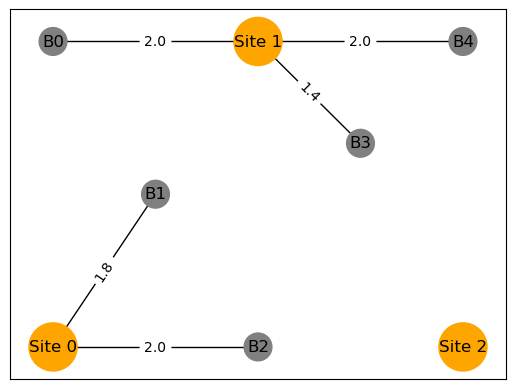

In [88]:
## More realistic toy example using (x,y) coordinates
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import distance



# Baseline scenario: 5 census blocks, 3 sites
v = np.array([400,400,400,400,400])     # no. of voters in each Census block
c = np.array([1,1,1])                   # operating costs for each site
k = np.array([1200,1200,1200])          # site capacities
BASELINE_VALUE = -1260.6408639915928    # computed value of objective for comparing with experiments

#k = np.array([400,400,1200])           
b = 3                                   # budget for operating sites.  Identical values for c reduces the budget constraint to a maximum total no. of sites 


# (x,y) coordinates for voting sites and Census block centroids
sites = {'Site 0':(0,0),'Site 1':(2,3),'Site 2':(4,0)}
voters = {'B0':(0,3),'B1':(1,1.5),'B2':(2,0),'B3':(3,2),'B4':(4,3)}  # base scenario

# EXPERIMENT SCENARIO PARAMETERS - uncomment these before running to see results
#voters = {'B0':(0,3),'B1':(1,1.5),'B2':(2,0),'B3':(3,1),'B4':(4,3)}  # experiment #1 - move B3 closer to Site 2
#c = np.array([10,1,1])                   # experiment #2 - increase operating cost for Site 0
#k = np.array([1200,800,1200])          # experiment #3 - reduce site capacity for Site 1
#c = np.array([10,1,1])                   # experiment #4 - increase operating cost for Site 0 AND increase capacity for site 1
#k = np.array([1200,1600,1200])           # experiment #4 - increase operating cost for Site 0 AND increase capacity for site 1

# Distance matrix
site_coords = np.array([sites[j] for j in sites.keys()])
voter_coords = np.array([voters[j] for j in voters.keys()])
d = distance.cdist(voter_coords,site_coords,'euclidean') 
print("Distance matrix:\n", d)
#d = np.array([[1,3,5],[2,1,3],[5,2,2],[2,3,2],[3,5,3]]) # distance matrix

# Voting probability (turnout rate) as a function of distance to voting site
def prob_fun(dist):
    return 1-dist/np.max(d)         # simple linear function for toy example. To substitute with estimates from research studies.
#p = {1:1,2:0.75,3:0.5,4:0.25,5:0}  #voting probabilities.  Values should be decreasing with distance.
w = 1  # weight parameter (1 gives equal weight to operating costs vs. voter costs)

n, m = d.shape  #number of Census blocks, voting sites

## Decision variables
X = cp.Variable(m, boolean=True)
Y = cp.Variable((n,m), boolean=True)  #rows=blocks, cols=sites
Z = cp.Variable((n,m), boolean=True)  # helper variables to eliminate non-convexity in objective function

## Constraints
e_i = np.ones((n,1))  # column of ones across blocks
e_j = np.ones((m,1))  # column of ones across voting sites 

constraints = [c.T @ X <= b,
               Y.T @ v <= k,
               Y @ e_j == e_i]

## Solve cost minimization problem
objective = 0
for i in range(n):
    for j in range(m):
#        objective += X[j] * Y[i][j] * p[d[i][j]] * v[i]   # This formulation of the objective function is non-convex so it won't work with CVXPY.  Need to linearize.
#        objective += Z[i][j] * p[d[i][j]] * v[i]
        objective += Z[i][j] * prob_fun(d[i][j]) * v[i]
        constraints.append(Z[i][j] <= X[j])                 # Constraints to linearize non-convexity involving product of two binary variables.
        constraints.append(Z[i][j] <= Y[i][j])
        constraints.append(Z[i][j] >= X[j] + Y[i][j] - 1)
        constraints.append(Y[i][j] <= X[j])  # Adding constraint that no census blocks can be assigned to an inactive voting site
objective = c.T @ X - w * objective
prob = cp.Problem(cp.Minimize(objective), constraints)
prob.solve()
print("Status:", prob.status)
print("Optimal value: {0}. \tDifference from baseline: {1}".format(prob.value,prob.value-BASELINE_VALUE))
print("Voting sites used:", X.value)
print("Voter assignments:\n", Y.value)


## Illustration with networkx graph

G = nx.Graph()
G.add_nodes_from(["Site {}".format(j) for j in range(m)])
G.add_nodes_from(["B{}".format(i) for i in range(n)])

def add_edge_to_graph(G, e1, e2, w):
    G.add_edge(e1, e2, weight=w)

for i in range(n):
    for j in range(m):
        if X.value[j] > 0 and Y.value[i][j] > 0:
            G.add_edge("B{}".format(i),"Site {}".format(j),weight=round(d[i][j],1))

#print(list(G.nodes))
#print(list(G.edges))

# Set node colors and sizes to differentiate sites and voters
node_colors = ['orange']*len(sites)+['grey']*len(voters)
#node_sizes = [1500]*len(sites)+[500]*len(voters)
node_sizes = list(k) + list(v)

fig, ax = plt.subplots()
# draw nodes and labels
nx.draw(G, pos=sites|voters, node_color=node_colors, node_size = node_sizes, ax=ax)
#nx.draw(G, pos=sites|voters, node_color='k', ax=ax)
#nx.draw(G, pos=sites|voters, node_size=1500, ax=ax)
nx.draw_networkx_labels(G, pos=sites|voters)
## draw edge weights (distance to site)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, sites|voters, edge_labels=labels, ax=ax)
plt.axis("on")
#ax.set_xlim(0,5)
#ax.set_ylim(0,5)
#ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()



In [60]:
[1500]*3+[500]*5

[1500, 1500, 1500, 500, 500, 500, 500, 500]

In [10]:
prob.solver_stats

SolverStats(solver_name='GLPK_MI', solve_time=None, setup_time=None, num_iters=None, extra_stats=None)

In [73]:
## Computing optimization data for Census blocks in Wake County
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import distance


# # Toy example with 5 census blocks, 3 sites
# v = np.array([400,400,400,400,400])     # no. of voters in each Census block
# c = np.array([1,1,1])                   # operating costs for each site. 
# k = np.array([1200,1200,1200])          # site capacities
# #k = np.array([400,400,1200])           
# b = 3                                   # budget for operating sites.  Identical values for c reduces the budget constraint to a maximum total no. of sites 


# # (x,y) coordinates for voting sites and Census block centroids
# sites = {'Site 0':(0,0),'Site 1':(2,3),'Site 2':(4,0)}
# voters = {'Voter 0':(0,3),'Voter 1':(1,1.5),'Voter 2':(2,0),'Voter 3':(3,2),'Voter 4':(4,3)}



# No. of registered voters in each Census block
block_voters = np.column_stack((Census_Blocks.total_reg,Census_Blocks.GEOID20))

# Voting site capacities - guestimate using voter turnout in the 2020 election
PP = Polling_Places.assign(prec_id = Polling_Places['USER_preci'].str.replace(r'PRECINCT ',''))
PP_CB_merge = PP.merge(Census_Blocks, on='prec_id',how='left')[['BLOCKCE20','prec_id','total_reg','g20201103_voted_all']]
#VP_lookup = CB_VP_merge.groupby('prec_id')[['total_reg','g20201103_voted_all']].sum().reset_index()
PP_lookup = PP_CB_merge.groupby('prec_id')[['BLOCKCE20','total_reg','g20201103_voted_all']].agg({'BLOCKCE20':'size','total_reg':'sum','g20201103_voted_all':'sum'}).reset_index()
capacities = np.column_stack((PP_lookup['g20201103_voted_all'],PP_lookup['prec_id']))

# Site operating costs and budget - assume same site numbers as 2020 election
site_costs = np.ones(len(capacities))
site_budget = len(capacities)

# Coordinates for voting sites and Census Blocks
sites = np.column_stack((PP.geometry.x,PP.geometry.y,PP.prec_id))
voters = np.column_stack((Census_Blocks.centroid.x, Census_Blocks.centroid.y,Census_Blocks.GEOID20))

# Distance matrix
site_coords = np.float32(sites[:,:-1])
voter_coords = np.float32(voters[:,:-1])
d = distance.cdist(voter_coords,site_coords,'euclidean')

# Voting probability (turnout rate) as a function of distance to voting site
def prob_fun(dist):
    return 1-dist/np.max(d)         # simple linear function for toy example. To substitute with estimates from research studies.
#p = {1:1,2:0.75,3:0.5,4:0.25,5:0}  #voting probabilities.  Values should be decreasing with distance.
w = 1  # weight parameter (1 gives equal weight to operating costs vs. voter costs)

n, m = d.shape  #number of Census blocks, voting sites

## Decision variables
X = cp.Variable(m, boolean=True)
Y = cp.Variable((n,m), boolean=True)  #rows=blocks, cols=sites
Z = cp.Variable((n,m), boolean=True)  # helper variables to eliminate non-convexity in objective function

## Constraints
e_i = np.ones((n,1))  # column of ones across blocks
e_j = np.ones((m,1))  # column of ones across voting sites 

constraints = [site_costs.T @ X <= site_budget,
               Y.T @ block_voters[:,0] <= capacities[:,0],
               Y @ e_j == e_i]

## Solve cost minimization problem
objective = 0
for i in range(n):
    for j in range(m):
#        objective += X[j] * Y[i][j] * p[d[i][j]] * v[i]   # This formulation of the objective function is non-convex so it won't work with CVXPY.  Need to linearize.
#        objective += Z[i][j] * p[d[i][j]] * v[i]
        objective += Z[i][j] * prob_fun(d[i][j]) * block_voters[i]
        constraints.append(Z[i][j] <= X[j])                 # Constraints to linearize non-convexity involving product of two binary variables.
        constraints.append(Z[i][j] <= Y[i][j])
        constraints.append(Z[i][j] >= X[j] + Y[i][j] - 1)
        constraints.append(Y[i][j] <= X[j])  # Adding constraint that no census blocks can be assigned to an inactive voting site
objective = c.T @ X - w * objective
prob = cp.Problem(cp.Minimize(objective), constraints)
prob.solve()
print("Status:", prob.status)
print("Optimal value:", prob.value)
print("Voting sites used:", X.value)
print("Voter assignments:\n", Y.value)


## Illustration with networkx graph

G = nx.Graph()
G.add_nodes_from(["Site {}".format(j) for j in range(m)])
G.add_nodes_from(["Voter {}".format(i) for i in range(n)])

def add_edge_to_graph(G, e1, e2, w):
    G.add_edge(e1, e2, weight=w)

for i in range(n):
    for j in range(m):
        if X.value[j] > 0 and Y.value[i][j] > 0:
            G.add_edge("Voter {}".format(i),"Site {}".format(j),weight=round(d[i][j],1))

#print(list(G.nodes))
#print(list(G.edges))

fig, ax = plt.subplots()
# draw nodes and labels
nx.draw(G, pos=sites|voters, node_color='k', ax=ax)
nx.draw(G, pos=sites|voters, node_size=1500, ax=ax)
nx.draw_networkx_labels(G, pos=sites|voters)
## draw edge weights (distance to site)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, sites|voters, edge_labels=labels, ax=ax)
plt.axis("on")
#ax.set_xlim(0,5)
#ax.set_ylim(0,5)
#ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

MemoryError: 

In [46]:
PP = Polling_Places.assign(prec_id = Polling_Places['USER_preci'].str.replace(r'PRECINCT ',''))
PP_CB_merge = PP.merge(Census_Blocks, on='prec_id',how='left')[['BLOCKCE20','prec_id','total_reg','g20201103_voted_all']]
PP_CB_merge[PP_CB_merge['prec_id'].str.contains("01-06|01-07")].dropna()

,BLOCKCE20,prec_id,total_reg,g20201103_voted_all
5633,1009,01-06,0.0,0.0
5634,1012,01-06,75.0,62.0
5635,1024,01-06,76.0,66.0
5636,1011,01-06,87.0,69.0
5637,2000,01-06,333.0,255.0
...,...,...,...,...
6129,2008,01-07,94.0,85.0
6130,3010,01-07,14.0,9.0
6131,3027,01-07,38.0,33.0
6132,3017,01-07,0.0,0.0


In [49]:
Public_Schools[Public_Schools['prec_id'].str.contains("01-06|01-07")]

,objectid,lea_school,ptmoved,comments,reviewed,school_nam,principal,street_lon,phys_addr,phys_city,...,bgn_grade,end_grade,pre_k,elem,middle,high,early_coll,prec_id,enr_desc,geometry
16,1582,920348,None,point verified,1,Needham Broughton High,Stephen Mares,723 Saint Marys St,723 Saint Mary's St,Raleigh,...,09,12,None,None,None,yes,None,01-06,PRECINCT 01-06,POINT (-8755543.165 4271735.671)
69,1635,920525,None,point verified,1,Partnership Elementary,Mark Kenjarski,601 Devereux Street,601 Devereux Street,Raleigh,...,KG,05,None,yes,None,None,None,01-06,PRECINCT 01-06,POINT (-8754958.427 4271769.018)
96,1663,920620,None,point verified,1,Wiley Elementary,Katie McMahon,301 Saint Mary's St,301 Saint Mary's St,Raleigh,...,KG,05,None,yes,None,None,None,01-07,PRECINCT 01-07,POINT (-8755428.709 4271079.903)
106,1835,92K000,"yes, 2012",down the street,1,Raleigh Charter High School,Thomas Humble,1111 Haynes Street,1307 Glenwood Avenue,Raleigh,...,09,12,None,None,None,yes,None,01-06,PRECINCT 01-06,POINT (-8755017.326 4272604.956)


In [88]:
gdf = pd.concat([PP['geometry'],Public_Schools['geometry']]).reset_index().drop('index',axis=1)
gdf.geometry.x

0     -8.771656e+06
1     -8.773679e+06
2     -8.773050e+06
3     -8.775133e+06
4     -8.772361e+06
           ...     
390   -8.773902e+06
391   -8.736376e+06
392   -8.738413e+06
393   -8.753913e+06
394   -8.753913e+06
Length: 395, dtype: float64

In [110]:
PP = Polling_Places.assign(prec_id = Polling_Places['USER_preci'].str.replace(r'PRECINCT ',''))
PP.merge(Census_Blocks, on='prec_id',how='left')['geometry_x']
PP_merge = PP.merge(Census_Blocks, on='prec_id',how='left')[['GEOID20','prec_id','total_reg','g20201103_voted_all','geometry_x']]
PP_merge.assign(geometry = PP_merge['geometry_x'])

,GEOID20,prec_id,total_reg,g20201103_voted_all,geometry_x,geometry
0,371830534212024,06-07,59.0,46.0,POINT (-8771656.396 4257269.096),POINT (-8771656.396 4257269.096)
1,371830534211014,06-07,16.0,14.0,POINT (-8771656.396 4257269.096),POINT (-8771656.396 4257269.096)
2,371830532101051,06-07,0.0,0.0,POINT (-8771656.396 4257269.096),POINT (-8771656.396 4257269.096)
3,371830534212007,06-07,65.0,59.0,POINT (-8771656.396 4257269.096),POINT (-8771656.396 4257269.096)
4,371830534212014,06-07,57.0,47.0,POINT (-8771656.396 4257269.096),POINT (-8771656.396 4257269.096)
...,...,...,...,...,...,...
13347,371830520012009,01-19,5.0,5.0,POINT (-8750431.418 4269525.130),POINT (-8750431.418 4269525.130)
13348,371830520021004,01-19,20.0,17.0,POINT (-8750431.418 4269525.130),POINT (-8750431.418 4269525.130)
13349,371830520021021,01-19,38.0,25.0,POINT (-8750431.418 4269525.130),POINT (-8750431.418 4269525.130)
13350,371830520012008,01-19,18.0,14.0,POINT (-8750431.418 4269525.130),POINT (-8750431.418 4269525.130)


Status: optimal
Optimal value: -4407.316490416883
Voting sites used: [1. 0. 1. 0. 0. 0. 1.]
Voter assignments:
 [[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]


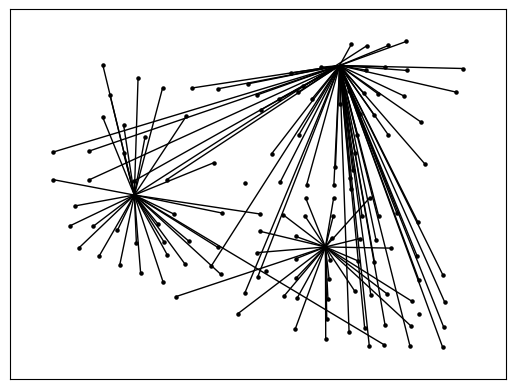

In [51]:
## Computing optimization data for selection of Census blocks in Wake County


# # Toy example with 5 census blocks, 3 sites
# v = np.array([400,400,400,400,400])     # no. of voters in each Census block
# c = np.array([1,1,1])                   # operating costs for each site. 
# k = np.array([1200,1200,1200])          # site capacities
# #k = np.array([400,400,1200])           
# b = 3                                   # budget for operating sites.  Identical values for c reduces the budget constraint to a maximum total no. of sites 


# # (x,y) coordinates for voting sites and Census block centroids
# sites = {'Site 0':(0,0),'Site 1':(2,3),'Site 2':(4,0)}
# voters = {'Voter 0':(0,3),'Voter 1':(1,1.5),'Voter 2':(2,0),'Voter 3':(3,2),'Voter 4':(4,3)}

import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import distance


# Pulling Census block data for selected precinct(s)
PP = Polling_Places.assign(prec_id = Polling_Places['USER_preci'].str.replace(r'PRECINCT ',''))
selected_PPs = PP[PP['prec_id'].str.contains("01-06|01-07")]
PP_CB_merge = PP.merge(Census_Blocks, on='prec_id',how='left')[['GEOID20','prec_id','total_reg','g20201103_voted_all']]
PP_CB_merge = PP_CB_merge[PP_CB_merge['prec_id'].str.contains("01-06|01-07")].dropna()
selected_blocks = Census_Blocks[Census_Blocks['prec_id'].str.contains("01-06|01-07")]

# Pulling public schools (potential voting sites) for selected precincts
selected_schools = Public_Schools[Public_Schools['prec_id'].str.contains("01-06|01-07")]

# No. of registered voters in each Census block
block_voters = np.column_stack((selected_blocks.total_reg,selected_blocks.GEOID20))

# Coordinates for voting sites (including schools) and Census Blocks
sites = np.column_stack((selected_PPs.geometry.x,selected_PPs.geometry.y))
sites = np.row_stack((sites,np.column_stack((selected_schools.geometry.x,selected_schools.geometry.y))))
#sites = np.column_stack((sites.geometry.x,sites.geometry.y))
blocks = np.column_stack((selected_blocks.centroid.x, selected_blocks.centroid.y))

# Site operating costs and budget - assume same site numbers as 2020 election
site_costs = np.ones(len(sites))
site_budget = 3

# Voting site capacities - guestimate using voter turnout in the 2020 election
PP_lookup = PP_CB_merge.groupby('prec_id')[['GEOID20','total_reg','g20201103_voted_all']].agg({'GEOID20':'size','total_reg':'sum','g20201103_voted_all':'sum'}).reset_index()
#capacities = np.column_stack((PP_lookup['g20201103_voted_all'],PP_lookup['prec_id']))
capacities = np.ones(len(sites)) * 2000

# Distance matrix
d = distance.cdist(np.float64(blocks),np.float64(sites),'euclidean')

# Voting probability (turnout rate) as a function of distance to voting site
def prob_fun(dist):
    return 1-dist/np.max(d)         # simple linear function for toy example. To substitute with estimates from research studies.
#p = {1:1,2:0.75,3:0.5,4:0.25,5:0}  #voting probabilities.  Values should be decreasing with distance.
w = 1  # weight parameter (1 gives equal weight to operating costs vs. voter costs)

n, m = d.shape  #number of Census blocks, voting sites

## Decision variables
X = cp.Variable(m, boolean=True)
Y = cp.Variable((n,m), boolean=True)  #rows=blocks, cols=sites
Z = cp.Variable((n,m), boolean=True)  # helper variables to eliminate non-convexity in objective function

## Constraints
e_i = np.ones((n,1))  # column of ones across blocks
e_j = np.ones((m,1))  # column of ones across voting sites 

constraints = [site_costs.T @ X <= site_budget,
               Y.T @ block_voters[:,0] <= capacities,
               Y @ e_j == e_i]

## Solve cost minimization problem
objective = 0
for i in range(n):
    for j in range(m):
#        objective += X[j] * Y[i][j] * p[d[i][j]] * v[i]   # This formulation of the objective function is non-convex so it won't work with CVXPY.  Need to linearize.
#        objective += Z[i][j] * p[d[i][j]] * v[i]
        objective += Z[i][j] * prob_fun(d[i][j]) * block_voters[i,0]
        constraints.append(Z[i][j] <= X[j])                 # Constraints to linearize non-convexity involving product of two binary variables.
        constraints.append(Z[i][j] <= Y[i][j])
        constraints.append(Z[i][j] >= X[j] + Y[i][j] - 1)
        constraints.append(Y[i][j] <= X[j])  # Adding constraint that no census blocks can be assigned to an inactive voting site
objective = site_costs.T @ X - w * objective
prob = cp.Problem(cp.Minimize(objective), constraints)
prob.solve(solver='GLPK_MI')
print("Status:", prob.status)
print("Optimal value:", prob.value)
print("Voting sites used:", X.value)
print("Voter assignments:\n", Y.value)


## Illustration with networkx graph

G = nx.Graph()
G.add_nodes_from(["Site {}".format(j) for j in range(m)])
G.add_nodes_from(["Voter {}".format(i) for i in range(n)])

def add_edge_to_graph(G, e1, e2, w):
    G.add_edge(e1, e2, weight=w)

for i in range(n):
    for j in range(m):
        if X.value[j] > 0 and Y.value[i][j] > 0:
            G.add_edge("Voter {}".format(i),"Site {}".format(j),weight=round(d[i][j],1))

#print(list(G.nodes))
#print(list(G.edges))

#sites = {'Site 0':(0,0),'Site 1':(2,3),'Site 2':(4,0)}
sites_draw = {"Site {}".format(j):(sites[j][0],sites[j][1]) for j in range(m)}
#voters = {'Voter 0':(0,3),'Voter 1':(1,1.5),'Voter 2':(2,0),'Voter 3':(3,2),'Voter 4':(4,3)}
blocks_draw = {"Voter {}".format(i):(blocks[i][0],blocks[i][1]) for i in range(n)}

fig, ax = plt.subplots()
# draw nodes and labels
nx.draw(G, pos=sites_draw|blocks_draw, node_color='k', node_size=5, ax=ax)
#nx.draw(G, pos=sites_draw|blocks_draw, node_size=5, ax=ax)
#nx.draw_networkx_labels(G, pos=sites_draw|blocks_draw)
## draw edge weights (distance to site)
labels = nx.get_edge_attributes(G, 'weight')
#nx.draw_networkx_edge_labels(G, sites_draw|blocks_draw, edge_labels=labels, ax=ax)
plt.axis("on")
#ax.set_xlim(0,5)
#ax.set_ylim(0,5)
#ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [126]:
np.sum(Y.value,axis=0)  #number of blocks assigned to each site

array([33.,  0., 29.,  0.,  0.,  0., 65.])

In [135]:
PP_lookup

,prec_id,GEOID20,total_reg,g20201103_voted_all
0,01-06,59,2703.0,2126.0
1,01-07,68,2818.0,2089.0


In [60]:
selected_PPs

,FID,Status,Score,Match_type,Match_addr,Addr_type,Place_addr,Side,StPreDir,StPreType,...,USER_pol_1,USER_preci,USER_house,USER_stree,USER_addre,USER_city,USER_state,USER_zip,geometry,prec_id
79,2080,M,100.00,A,"1930 Clark Ave, Raleigh, North Carolina, 27605",StreetAddress,"1930 Clark Ave, Raleigh, North Carolina, 27605",L,None,None,...,CAMERON VILLAGE REGIONAL LIBRA,PRECINCT 01-06,1930,CLARK AVE,1930 CLARK AVE,RALEIGH,NC,27605,POINT (-8756160.265 4271643.927),01-06
90,2091,M,99.55,A,"301 W Jones St, Raleigh, North Carolina, 27603",PointAddress,"301 W Jones St, Raleigh, North Carolina, 27603",None,W,None,...,EDENTON STREET UNITED METHODIS,PRECINCT 01-07,301,JONES ST,301 JONES ST,RALEIGH,NC,27603,POINT (-8754574.741 4270762.293),01-07
98,2099,M,100.00,A,"616 Tucker St, Raleigh, North Carolina, 27603",PointAddress,"616 Tucker St, Raleigh, North Carolina, 27603",None,None,None,...,SAINT SAVIOUR'S CENTER,PRECINCT 01-07A,616,TUCKER ST,616 TUCKER ST,RALEIGH,NC,27603,POINT (-8755095.991 4271258.732),01-07A


In [58]:
selected_schools
#school_ind = 3
#PP[(PP.geometry.x == selected_schools[school_ind][0]) & (PP.geometry.y == selected_schools[school_ind][1])]

,objectid,lea_school,ptmoved,comments,reviewed,school_nam,principal,street_lon,phys_addr,phys_city,...,bgn_grade,end_grade,pre_k,elem,middle,high,early_coll,prec_id,enr_desc,geometry
16,1582,920348,None,point verified,1,Needham Broughton High,Stephen Mares,723 Saint Marys St,723 Saint Mary's St,Raleigh,...,09,12,None,None,None,yes,None,01-06,PRECINCT 01-06,POINT (-8755543.165 4271735.671)
69,1635,920525,None,point verified,1,Partnership Elementary,Mark Kenjarski,601 Devereux Street,601 Devereux Street,Raleigh,...,KG,05,None,yes,None,None,None,01-06,PRECINCT 01-06,POINT (-8754958.427 4271769.018)
96,1663,920620,None,point verified,1,Wiley Elementary,Katie McMahon,301 Saint Mary's St,301 Saint Mary's St,Raleigh,...,KG,05,None,yes,None,None,None,01-07,PRECINCT 01-07,POINT (-8755428.709 4271079.903)
106,1835,92K000,"yes, 2012",down the street,1,Raleigh Charter High School,Thomas Humble,1111 Haynes Street,1307 Glenwood Avenue,Raleigh,...,09,12,None,None,None,yes,None,01-06,PRECINCT 01-06,POINT (-8755017.326 4272604.956)


In [77]:
inds = np.ma.make_mask(Y.value[:,0])
blocks_0 = selected_blocks.loc[inds,['GEOID20','prec_id','g20201103_reg_all','geometry']]

In [8]:
import folium

# explore() is a geopandas method to create interactive maps.
# we assign it to the variable 'combined_map', to add more map layers after.

selected_precincts = Voting_Precincts[Voting_Precincts['prec_id'].str.contains("01-06|01-07")]

combined_map = selected_precincts.explore(
    color="blue",
#    column="enr_desc",  # Make choropleth based on "category" column.
    tooltip="enr_desc",  # Show "name" value in tooltip (on hover)
    # Do not show column label in the tooltip.
    tooltip_kwds=dict(labels=False),
    cmap="gnuplot2",  # Use "gnuplot2" matplotlib color scheme.
    style_kwds=dict(
        fill=True, opacity=1.0, fillOpacity=0.0, interactive=True
    ),
    smooth_factor=0,
    name="Voting_Precincts",  # Name of the layer in the map.
)

# Add blocks for voting site 0
inds = np.ma.make_mask(Y.value[:,0])
blocks_0 = selected_blocks.loc[inds,['GEOID20','prec_id','g20201103_reg_all','geometry']]
blocks_0 = blocks_0[blocks_0['g20201103_reg_all']>0]
blocks_0.explore(
    m=combined_map,  # Pass the previous map object
    color="brown",  # Use black color for borders.
#    column="g20201103_reg_all",  # Make choropleth based on "total_reg" column.
#    cmap = "afmhot_r", #color scheme
    # Styling instructions. We fill the wards with lightgrey color (when hovering over them),
    # and change the opacity of different elements.
    style_kwds=dict(
        fill=True, opacity=0.0, fillOpacity=0.5, interactive=True
    ),
    tiles="OpenStreetMap",  # Use Open Street Map background tiles.
#    tiles="CartoDB positron",
    tooltip=["GEOID20"],  # Do not show tooltip when hovering on wards.
    popup=["GEOID20", "prec_id","g20201103_reg_all"],  # Show the name of the ward on click.
    # Do not show the column label "ward_name" in the popup.
#    popup_kwds=dict(labels=False),
    smooth_factor=0,  # Prevent smoothing of the polygons edges.
    name="blocks_0",  # Name of the layer in the map.
)

# Add blocks for voting site 2
inds = np.ma.make_mask(Y.value[:,2])
blocks_2 = selected_blocks.loc[inds,['GEOID20','prec_id','g20201103_reg_all','geometry']]
blocks_2 = blocks_2[blocks_2['g20201103_reg_all']>0]
blocks_2.explore(
    m=combined_map,  # Pass the previous map object
    color="red",  # Use black color for borders.
#    column="g20201103_reg_all",  # Make choropleth based on "total_reg" column.
#    cmap = "afmhot_r", #color scheme
    # Styling instructions. We fill the wards with lightgrey color (when hovering over them),
    # and change the opacity of different elements.
    style_kwds=dict(
        fill=True, opacity=0.0, fillOpacity=0.5, interactive=True
    ),
    tiles="OpenStreetMap",  # Use Open Street Map background tiles.
#    tiles="CartoDB positron",
    tooltip=["GEOID20"],  # Do not show tooltip when hovering on wards.
    popup=["GEOID20", "prec_id","g20201103_reg_all"],  # Show the name of the ward on click.
    # Do not show the column label "ward_name" in the popup.
#    popup_kwds=dict(labels=False),
    smooth_factor=0,  # Prevent smoothing of the polygons edges.
    name="blocks_2",  # Name of the layer in the map.
)

# Add blocks for voting site 6
inds = np.ma.make_mask(Y.value[:,6])
blocks_6 = selected_blocks.loc[inds,['GEOID20','prec_id','g20201103_reg_all','geometry']]
blocks_6 = blocks_6[blocks_6['g20201103_reg_all']>0]
blocks_6.explore(
    m=combined_map,  # Pass the previous map object
    color="orange",  # Use black color for borders.
#    column="g20201103_reg_all",  # Make choropleth based on "total_reg" column.
#    cmap = "afmhot_r", #color scheme
    # Styling instructions. We fill the wards with lightgrey color (when hovering over them),
    # and change the opacity of different elements.
    style_kwds=dict(
        fill=True, opacity=0.0, fillOpacity=0.5, interactive=True
    ),
    tiles="OpenStreetMap",  # Use Open Street Map background tiles.
#    tiles="CartoDB positron",
    tooltip=["GEOID20"],  # Do not show tooltip when hovering on wards.
    popup=["GEOID20", "prec_id","g20201103_reg_all"],  # Show the name of the ward on click.
    # Do not show the column label "ward_name" in the popup.
#    popup_kwds=dict(labels=False),
    smooth_factor=0,  # Prevent smoothing of the polygons edges.
    name="blocks_6",  # Name of the layer in the map.
)


# Add Polling Places as third layer
selected_PPs.explore(
    m=combined_map,  # Pass the previous map object.
#    column="USER_count",  # Make choropleth based on "category" column.
    tooltip=["USER_pol_1","USER_preci"],  # Show values in tooltip (on hover)
    # Do not show column label in the tooltip.
    tooltip_kwds=dict(labels=False),
    # Show the selected values in popup (on click).
    popup=["USER_count", "USER_pol_1", "USER_preci"],
#    cmap="gnuplot2",  # Use "gnuplot2" matplotlib color scheme.
    marker_kwds=dict(radius=5),  # Size of the points.
    # Styling instructions. We draw small black circles around our points,
    # and change the opacity of different elements.
    style_kwds=dict(color="black", weight=1, fill=True, opacity=0.5, fillOpacity=0.8),
    name="Polling_Places",  # Name of the layer in the map.
)

# Add schools
selected_schools.explore(
    m=combined_map,  # Pass the previous map object.
    color="purple",
#    column="USER_count",  # Make choropleth based on "category" column.
    tooltip=["school_nam"],  # Show values in tooltip (on hover)
    # Do not show column label in the tooltip.
    tooltip_kwds=dict(labels=False),
    # Show the selected values in popup (on click).
#    popup=["USER_count", "USER_pol_1", "USER_preci"],
#    cmap="gnuplot2",  # Use "gnuplot2" matplotlib color scheme.
    marker_kwds=dict(radius=5),  # Size of the points.
    # Styling instructions. We draw small black circles around our points,
    # and change the opacity of different elements.
    style_kwds=dict(color="black", weight=1, fill=True, opacity=0.5, fillOpacity=1),
    name="Schools",  # Name of the layer in the map.
)

# Adding markers to voting sites assigned by the model
selected_sites = pd.concat([gpd.GeoSeries(selected_schools.iloc[3,:]['geometry']),selected_PPs.iloc[[0,2]]['geometry']],ignore_index=True)
folium.GeoJson(
    selected_sites,
    marker=folium.Marker(icon=folium.Icon(icon='star'))
).add_to(combined_map)

# VP_select = "01-07"
# selected_gdf = Voting_Precincts[Voting_Precincts['prec_id']==VP_select]
# selected_gdf.explore(
#     m=combined_map,
#     color="yellow",
#     smooth_factor=0,
#     name="selected_precinct",  # Name of the layer in the map.
# )



# Use the folium library (which Geopandas is based on for interactive mapping) to add layer control
folium.LayerControl().add_to(combined_map)


# #display(selected_gdf)
# sim_geo = gpd.GeoSeries(selected_gdf["geometry"])
# #sim_geo = gpd.GeoSeries(selected_gdf["geometry"]).simplify(tolerance=0.001)
# geo_j = sim_geo.to_json()
# #print(geo_j)
# geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
# #folium.Popup(selected_gdf["prec_id"]).add_to(geo_j)
# geo_j.add_to(combined_map)

combined_map

NameError: name 'Y' is not defined

In [134]:
blocks_0[blocks_0['GEOID20'] == "371830512002013"]

,GEOID20,prec_id,g20201103_reg_all,geometry
7860,371830512002013,01-07,45,"MULTIPOLYGON (((-8755850.475 4271236.863, -875..."


In [113]:
dataframesList = [selected_schools.iloc[3,:],selected_PPs.iloc[[0,2]]]
gpd.GeoDataFrame(pd.concat(dataframesList, ignore_index=True), crs=dataframesList[0].crs)

AttributeError: 'Series' object has no attribute 'crs'

In [121]:
pd.concat([gpd.GeoSeries(selected_schools.iloc[3,:]['geometry']),selected_PPs.iloc[[0,2]]['geometry']],ignore_index=True)

c:\ProgramData\Anaconda3\envs\cse6242_project2\Lib\site-packages\geopandas\array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / Pseudo-Mercator (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


0    POINT (-8755017.326 4272604.956)
1    POINT (-8756160.265 4271643.927)
2    POINT (-8755095.991 4271258.732)
dtype: geometry

In [9]:
# General purpose libraries.
import pandas as pd
import os
import numpy as np
import random

# Geospatial libraries.
import geopandas as gpd
#import rasterio
#from rasterio.plot import show
import folium
import shapely

# For optimization
import cvxpy as cp
import networkx as nx
from scipy.spatial import distance

# 
scenarios = pd.DataFrame(columns=["Voting precincts","Max. number of sites to assign"], data=[["01-37|01-15|01-17|01-30",4],["01-06|01-07",3]])
#precinct_select = "01-37|01-15|01-17|01-30"
#precinct_select = "01-06|01-07"
scenario_num = 1
precinct_select = scenarios['Voting precincts'][scenario_num]
maxsites_select = scenarios['Max. number of sites to assign'][scenario_num]

selected_precincts = Voting_Precincts[Voting_Precincts['prec_id'].str.contains(precinct_select)]

# Pulling Census block data for selected precinct(s)
PP = Polling_Places.assign(prec_id = Polling_Places['USER_preci'].str.replace(r'PRECINCT ',''))
selected_PPs = PP[PP['prec_id'].str.contains(precinct_select)]
PP_CB_merge = PP.merge(Census_Blocks, on='prec_id',how='left')[['GEOID20','prec_id','total_reg','g20201103_voted_all']]
PP_CB_merge = PP_CB_merge[PP_CB_merge['prec_id'].str.contains(precinct_select)].dropna()
selected_blocks = Census_Blocks[Census_Blocks['prec_id'].str.contains(precinct_select)]

# Pulling public schools (potential voting sites) for selected precincts
selected_schools = Public_Schools[Public_Schools['prec_id'].str.contains(precinct_select)]

# No. of registered voters in each Census block
block_voters = np.column_stack((selected_blocks.total_reg,selected_blocks.GEOID20))

# Combining polling places and schools into one GeoPandas object
sites = gpd.GeoDataFrame(pd.concat([selected_PPs[['geometry','USER_pol_1']].rename(columns={'USER_pol_1':'name'}),
                                    selected_schools[['geometry','school_nam']].rename(columns={'school_nam':'name'})],
                                    ignore_index=True))

# Coordinates for voting sites (including schools) and Census Blocks
#sites = np.column_stack((selected_PPs.geometry.x,selected_PPs.geometry.y))
#sites = np.row_stack((sites,np.column_stack((selected_schools.geometry.x,selected_schools.geometry.y))))
site_coords = np.column_stack((sites.geometry.x,sites.geometry.y))
block_coords = np.column_stack((selected_blocks.centroid.x, selected_blocks.centroid.y))

# Site operating costs and budget - assume same site numbers as 2020 election
site_costs = np.ones(len(sites))
#site_budget = max(3,len(precinct_select.split("|")))
site_budget = maxsites_select

# Voting site capacities - guestimate using voter turnout in the 2020 election
PP_lookup = PP_CB_merge.groupby('prec_id')[['GEOID20','total_reg','g20201103_voted_all']].agg({'GEOID20':'size','total_reg':'sum','g20201103_voted_all':'sum'}).reset_index()
#capacities = np.column_stack((PP_lookup['g20201103_voted_all'],PP_lookup['prec_id']))
capacities = np.ones(len(sites)) * 2000

#@st.cache_data
def solve_model(w=1):  # weight parameter w (1 gives equal weight to operating costs vs. voter costs)
    # Distance matrix
    d = distance.cdist(np.float64(block_coords),np.float64(site_coords),'euclidean')

    # Voting probability (turnout rate) as a function of distance to voting site
    def prob_fun(dist):
        return 1-dist/np.max(d)         # simple linear function for toy example. To substitute with estimates from research studies.
    #p = {1:1,2:0.75,3:0.5,4:0.25,5:0}  #voting probabilities.  Values should be decreasing with distance.
    
    n, m = d.shape  #number of Census blocks, voting sites

    ## Decision variables
    X = cp.Variable(m, boolean=True)
    Y = cp.Variable((n,m), boolean=True)  #rows=blocks, cols=sites
    Z = cp.Variable((n,m), boolean=True)  # helper variables to eliminate non-convexity in objective function

    ## Constraints
    e_i = np.ones((n,1))  # column of ones across blocks
    e_j = np.ones((m,1))  # column of ones across voting sites 

    constraints = [site_costs.T @ X <= site_budget,
                Y.T @ block_voters[:,0] <= capacities,
                Y @ e_j == e_i]

    ## Solve cost minimization problem
    objective = 0
    for i in range(n):
        for j in range(m):
    #        objective += X[j] * Y[i][j] * p[d[i][j]] * v[i]   # This formulation of the objective function is non-convex so it won't work with CVXPY.  Need to linearize.
    #        objective += Z[i][j] * p[d[i][j]] * v[i]
            objective += Z[i][j] * prob_fun(d[i][j]) * block_voters[i,0]
            constraints.append(Z[i][j] <= X[j])                 # Constraints to linearize non-convexity involving product of two binary variables.
            constraints.append(Z[i][j] <= Y[i][j])
            constraints.append(Z[i][j] >= X[j] + Y[i][j] - 1)
            constraints.append(Y[i][j] <= X[j])  # Adding constraint that no census blocks can be assigned to an inactive voting site
    objective = site_costs.T @ X - w * objective
    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve()
    #prob.solve(solver='GLPK_MI')
    print("Status:", prob.status)
    print("Optimal value:", prob.value)
    print("Voting sites used:", X.value)
    print("Voter assignments:\n", Y.value)
    
    return prob.status, prob.value, X.value, Y.value

_, _, X_val, Y_val = solve_model()

## Building map using geopandas.explore and folium

combined_map = selected_precincts.explore(
    color="blue",
#    column="enr_desc",  # Make choropleth based on "category" column.
    tooltip="enr_desc",  # Show "name" value in tooltip (on hover)
    # Do not show column label in the tooltip.
    tooltip_kwds=dict(labels=False),
    cmap="gnuplot2",  # Use "gnuplot2" matplotlib color scheme.
    style_kwds=dict(
        fill=True, opacity=1.0, fillOpacity=0.0, interactive=True
    ),
    smooth_factor=0,
    name="Voting_Precincts",  # Name of the layer in the map.
)

# Add blocks for each active voting site
active_sites = np.nonzero(X_val)[0]
for i in active_sites:
    inds = np.ma.make_mask(Y_val[:,i])
    blocks = selected_blocks.loc[inds,['GEOID20','prec_id','g20201103_reg_all','geometry']]
    blocks = blocks[blocks['g20201103_reg_all']>0]
    blocks.explore(
        m=combined_map,  # Pass the previous map object
    #    color="brown",
        color="#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)]),  # Use random color for borders.
    #    column="g20201103_reg_all",  # Make choropleth based on "total_reg" column.
    #    cmap = "afmhot_r", #color scheme
        # Styling instructions. We fill the wards with lightgrey color (when hovering over them),
        # and change the opacity of different elements.
        style_kwds=dict(
            fill=True, opacity=0.0, fillOpacity=0.5, interactive=True
        ),
        tiles="OpenStreetMap",  # Use Open Street Map background tiles.
    #    tiles="CartoDB positron",
        tooltip=["GEOID20","g20201103_reg_all"],  # Do not show tooltip when hovering on wards.
        popup=["GEOID20", "prec_id","g20201103_reg_all"],  # Show the name of the ward on click.
        # Do not show the column label "ward_name" in the popup.
    #    popup_kwds=dict(labels=False),
        smooth_factor=0,  # Prevent smoothing of the polygons edges.
        name="blocks{}".format(i),  # Name of the layer in the map.
    )

# # Add blocks for voting site 1
# inds = np.ma.make_mask(Y_val[:,1])
# blocks_1 = selected_blocks.loc[inds,['GEOID20','prec_id','g20201103_reg_all','geometry']]
# blocks_1 = blocks_1[blocks_1['g20201103_reg_all']>0]
# blocks_1.explore(
#     m=combined_map,  # Pass the previous map object
# #    color="green",
#     color="#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)]),  # Use random color for borders.
# #    column="g20201103_reg_all",  # Make choropleth based on "total_reg" column.
# #    cmap = "afmhot_r", #color scheme
#     # Styling instructions. We fill the wards with lightgrey color (when hovering over them),
#     # and change the opacity of different elements.
#     style_kwds=dict(
#         fill=True, opacity=0.0, fillOpacity=0.5, interactive=True
#     ),
#     tiles="OpenStreetMap",  # Use Open Street Map background tiles.
# #    tiles="CartoDB positron",
#     tooltip=["GEOID20","g20201103_reg_all"],  # Do not show tooltip when hovering on wards.
#     popup=["GEOID20", "prec_id","g20201103_reg_all"],  # Show the name of the ward on click.
#     # Do not show the column label "ward_name" in the popup.
# #    popup_kwds=dict(labels=False),
#     smooth_factor=0,  # Prevent smoothing of the polygons edges.
#     name="blocks_1",  # Name of the layer in the map.
# )

# # Add blocks for voting site 2
# inds = np.ma.make_mask(Y_val[:,2])
# blocks_2 = selected_blocks.loc[inds,['GEOID20','prec_id','g20201103_reg_all','geometry']]
# blocks_2 = blocks_2[blocks_2['g20201103_reg_all']>0]
# blocks_2.explore(
#     m=combined_map,  # Pass the previous map object
# #    color="red",  # Use black color for borders.
#     color="#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)]),  # Use random color for borders.
# #    column="g20201103_reg_all",  # Make choropleth based on "total_reg" column.
# #    cmap = "afmhot_r", #color scheme
#     # Styling instructions. We fill the wards with lightgrey color (when hovering over them),
#     # and change the opacity of different elements.
#     style_kwds=dict(
#         fill=True, opacity=0.0, fillOpacity=0.5, interactive=True
#     ),
#     tiles="OpenStreetMap",  # Use Open Street Map background tiles.
# #    tiles="CartoDB positron",
#     tooltip=["GEOID20","g20201103_reg_all"],  # Do not show tooltip when hovering on wards.
#     popup=["GEOID20", "prec_id","g20201103_reg_all"],  # Show the name of the ward on click.
#     # Do not show the column label "ward_name" in the popup.
# #    popup_kwds=dict(labels=False),
#     smooth_factor=0,  # Prevent smoothing of the polygons edges.
#     name="blocks_2",  # Name of the layer in the map.
# )

# # Add blocks for voting site 5
# inds = np.ma.make_mask(Y_val[:,5])
# blocks_5 = selected_blocks.loc[inds,['GEOID20','prec_id','g20201103_reg_all','geometry']]
# blocks_5 = blocks_5[blocks_5['g20201103_reg_all']>0]
# blocks_5.explore(
#     m=combined_map,  # Pass the previous map object
# #    color="orange",  # Use black color for borders.
#     color="#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)]),  # Use random color for borders.
# #    column="g20201103_reg_all",  # Make choropleth based on "total_reg" column.
# #    cmap = "afmhot_r", #color scheme
#     # Styling instructions. We fill the wards with lightgrey color (when hovering over them),
#     # and change the opacity of different elements.
#     style_kwds=dict(
#         fill=True, opacity=0.0, fillOpacity=0.5, interactive=True
#     ),
#     tiles="OpenStreetMap",  # Use Open Street Map background tiles.
# #    tiles="CartoDB positron",
#     tooltip=["GEOID20","g20201103_reg_all"],  # Do not show tooltip when hovering on wards.
#     popup=["GEOID20", "prec_id","g20201103_reg_all"],  # Show the name of the ward on click.
#     # Do not show the column label "ward_name" in the popup.
# #    popup_kwds=dict(labels=False),
#     smooth_factor=0,  # Prevent smoothing of the polygons edges.
#     name="blocks_5",  # Name of the layer in the map.
# )


# Add Polling Places as third layer
selected_PPs.explore(
    m=combined_map,  # Pass the previous map object.
#    column="USER_count",  # Make choropleth based on "category" column.
    tooltip=["USER_pol_1","USER_preci"],  # Show values in tooltip (on hover)
    # Do not show column label in the tooltip.
    tooltip_kwds=dict(labels=False),
    # Show the selected values in popup (on click).
    popup=["USER_count", "USER_pol_1", "USER_preci"],
#    cmap="gnuplot2",  # Use "gnuplot2" matplotlib color scheme.
    marker_kwds=dict(radius=5),  # Size of the points.
    # Styling instructions. We draw small black circles around our points,
    # and change the opacity of different elements.
    style_kwds=dict(color="black", weight=1, fill=True, opacity=0.5, fillOpacity=0.8),
    name="Polling_Places",  # Name of the layer in the map.
)

# Add schools
selected_schools.explore(
    m=combined_map,  # Pass the previous map object.
    color="purple",
#    column="USER_count",  # Make choropleth based on "category" column.
    tooltip=["school_nam"],  # Show values in tooltip (on hover)
    # Do not show column label in the tooltip.
    tooltip_kwds=dict(labels=False),
    # Show the selected values in popup (on click).
#    popup=["USER_count", "USER_pol_1", "USER_preci"],
#    cmap="gnuplot2",  # Use "gnuplot2" matplotlib color scheme.
    marker_kwds=dict(radius=5),  # Size of the points.
    # Styling instructions. We draw small black circles around our points,
    # and change the opacity of different elements.
    style_kwds=dict(color="black", weight=1, fill=True, opacity=0.5, fillOpacity=1),
    name="Schools",  # Name of the layer in the map.
)

# Adding markers to voting sites assigned by the model
#selected_sites = pd.concat([gpd.GeoSeries(selected_schools.iloc[1,:][['geometry','school_nam']].rename({'school_nam':'name'})),
#                            selected_PPs.iloc[[0,1,2]][['geometry','USER_pol_1']].rename({'USER_pol_1':'name'})],ignore_index=True)
#selected_sites = pd.concat([gpd.GeoSeries(selected_schools.iloc[3,:]['geometry']),selected_PPs.iloc[[0,2]]['geometry']],ignore_index=True)
#selected_sites = gpd.GeoDataFrame(selected_sites)
selected_sites = sites.loc[np.where(X_val)]
#selected_sites = selected_sites.rename(columns={0:'geometry'}).set_geometry('geometry')
#selected_site_names = pd.concat([selected_PPs['USER_pol_1'],selected_schools['school_nam']],ignore_index=True)
#selected_site_names = [selected_site_names[i] for i in np.where(X_val)]
#selected_sites = selected_sites.assign(name = selected_site_names)
#selected_sites = selected_sites.assign(name = ['Carroll Middle','BROOKS MUSEUMS MAGNET ELEMENTARY','HUDSON MEMORIAL PRESBYTERIAN','DOUGLAS ELEMENTARY SCHOOL'])
#selected_sites = selected_sites.assign(name = ["CAMERON VILLAGE REGIONAL LIBRARY","SAINT SAVIOUR'S CENTER","Raleigh Charter High School"])
folium.GeoJson(
   selected_sites,
   marker=folium.Marker(icon=folium.Icon(icon='star')),
   popup=folium.GeoJsonPopup(fields=["name"])
).add_to(combined_map)

# Use the folium library (which Geopandas is based on for interactive mapping) to add layer control
folium.LayerControl().add_to(combined_map)

combined_map

Status: optimal
Optimal value: -4407.316490416883
Voting sites used: [1. 0. 1. 0. 0. 0. 1.]
Voter assignments:
 [[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]


In [7]:
type(scenarios)

tuple

In [104]:
gpd.GeoDataFrame(pd.concat([selected_PPs.geometry,selected_schools.geometry]))

gpd.GeoDataFrame(pd.concat([selected_PPs[['geometry','USER_pol_1']].rename(columns={'USER_pol_1':'name'}),selected_schools[['geometry','school_nam']].rename(columns={'school_nam':'name'})],ignore_index=True))

,geometry,name
0,POINT (-8755763.714 4279206.452),BROOKS MUSEUMS MAGNET ELEMENTA
1,POINT (-8754715.737 4279875.675),HUDSON MEMORIAL PRESBYTERIAN C
2,POINT (-8752982.122 4278771.340),DOUGLAS ELEMENTARY SCHOOL
3,POINT (-8754708.282 4279372.075),ST MARKS UNITED METHODIST CHUR
4,POINT (-8755756.644 4279258.036),Brooks Elementary
5,POINT (-8754438.103 4279039.049),Carroll Middle
6,POINT (-8753017.480 4278735.440),Douglas Elementary
7,POINT (-8754590.910 4280633.349),Green Elementary


In [73]:
selected_sites = pd.concat([selected_schools.iloc[1,:][['geometry','school_nam']].rename({'school_nam':'name'}),
                            selected_PPs.iloc[[0,1,2]][['geometry','USER_pol_1']].rename({'USER_pol_1':'name'})],ignore_index=True)

site_names = pd.concat([selected_PPs['USER_pol_1'],selected_schools['school_nam']],ignore_index=True)
[site_names[i] for i in np.where(X_val)]

[0    BROOKS MUSEUMS MAGNET ELEMENTA
 1    HUDSON MEMORIAL PRESBYTERIAN C
 2         DOUGLAS ELEMENTARY SCHOOL
 5                    Carroll Middle
 dtype: object]

In [39]:
["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])]

['#2D72DB']

In [12]:
pd.concat([gpd.GeoSeries(selected_schools.iloc[1,:]['geometry']),selected_PPs.iloc[[0,1,2]]['geometry']],ignore_index=True)

c:\ProgramData\Anaconda3\envs\cse6242_project2\Lib\site-packages\geopandas\array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / Pseudo-Mercator (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


0    POINT (-8754438.103 4279039.049)
1    POINT (-8755763.714 4279206.452)
2    POINT (-8754715.737 4279875.675)
3    POINT (-8752982.122 4278771.340)
dtype: geometry

In [17]:
selected_PPs[['geometry','USER_pol_1']]

,geometry,USER_pol_1
45,POINT (-8755763.714 4279206.452),BROOKS MUSEUMS MAGNET ELEMENTA
58,POINT (-8754715.737 4279875.675),HUDSON MEMORIAL PRESBYTERIAN C
165,POINT (-8752982.122 4278771.340),DOUGLAS ELEMENTARY SCHOOL
185,POINT (-8754708.282 4279372.075),ST MARKS UNITED METHODIST CHUR


In [19]:
selected_schools[['geometry','school_nam']]

,geometry,school_nam
15,POINT (-8755756.644 4279258.036),Brooks Elementary
19,POINT (-8754438.103 4279039.049),Carroll Middle
29,POINT (-8753017.480 4278735.440),Douglas Elementary
42,POINT (-8754590.910 4280633.349),Green Elementary


In [47]:
selected_precincts

,objectid,id,prec_id,enr_desc,county_nam,of_prec_id,county_id,st_areasha,st_perimet,geometry
12,2403,121,01-17,PRECINCT 01-17,WAKE,None,92,1.534636e+07,18649.294769,"MULTIPOLYGON (((-8755979.031 4278145.974, -875..."
14,2405,118,01-15,PRECINCT 01-15,WAKE,None,92,2.033638e+07,19471.346049,"MULTIPOLYGON (((-8752898.259 4277345.044, -875..."
29,2420,133,01-30,PRECINCT 01-30,WAKE,None,92,1.873760e+07,20177.040273,"MULTIPOLYGON (((-8755976.359 4278168.082, -875..."
37,2428,140,01-37,PRECINCT 01-37,WAKE,None,92,2.256959e+07,25859.310225,"MULTIPOLYGON (((-8752621.625 4279030.582, -875..."
